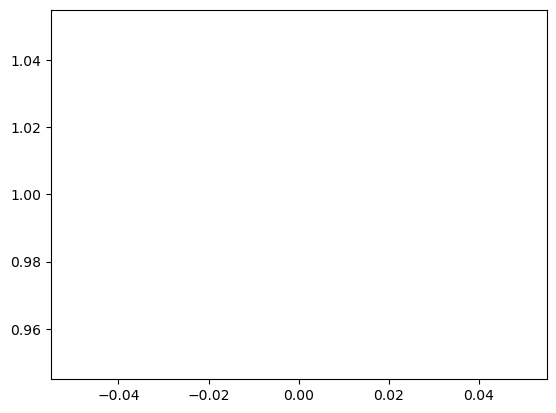

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch

import matplotlib.pyplot as plt
plt.plot([1])
plt.show()

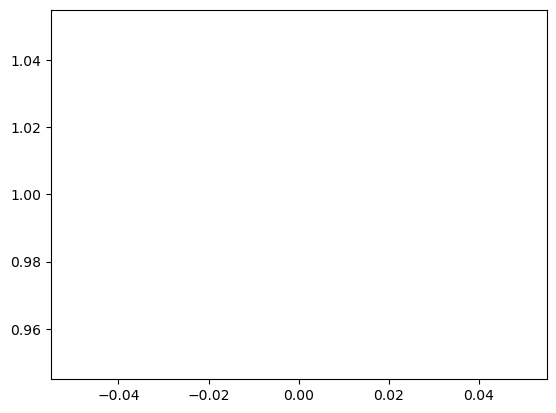

In [4]:
plt.plot([1])
plt.show()

In [3]:
alphabet_dict = {"p": 0, "-": 1, "A": 2, "C": 3, "G": 4, "T": 5}
lab2onehot =  lambda seq: torch.eye(len(alphabet_dict))[seq]
seq2lab = lambda seq: torch.tensor([alphabet_dict[i] for i in seq])

In [4]:
def label(seqs, alphabet_dict):
    assert any(seqs), "empty sequence input"
    assert any([len(seq) != len(seq[0]) for seq in seqs])
    encoded_seqs = torch.ones((len(seqs), len(seqs[0])))
    for i,seq in enumerate(seqs):
        encoded_seq = torch.tensor([alphabet_dict[a] for a in seq])
        encoded_seqs[i,:] = encoded_seq
    return encoded_seqs

def onehot(seqs, alphabet_dict):
    assert any(seqs), "empty sequence input"
    assert any([len(seq) != len(seq[0]) for seq in seqs])
    encoded_seqs = torch.ones((len(seqs), len(seqs[0]), len(alphabet_dict)))
    for i,seq in enumerate(seqs):
        encoded_seq = seq2lab(seq)
        encoded_seq_onehot = lab2onehot(encoded_seq)
        encoded_seqs[i,:,:] = encoded_seq_onehot
    return encoded_seqs

def calculate_prob_matrix(seqs, alphabet_dict):    
    onehot_vect = onehot(seqs, alphabet_dict)
    return (onehot_vect.sum(dim=0).T / onehot_vect.sum(dim=[0,2])).T

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, num_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, num_channels, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
df_aligned = pd.read_csv("C:/Users/khoah/PhD_Documents/SPLASH/compactor_classified_small_aligned.csv")


In [7]:
msas = df_aligned.groupby("anchor_index").agg(list).aligned_compactor.to_list()
msa_prob_encoded = [calculate_prob_matrix(msa, alphabet_dict) for msa in msas]
padded_sequences = pad_sequence(msa_prob_encoded, batch_first=True, padding_value=0)
input_seqs = torch.swapaxes(padded_sequences, 1,2)

In [8]:
# divide into train and test set
train_size = int(0.8 * len(input_seqs))
test_size = len(input_seqs) - train_size
train_set, test_set = torch.utils.data.random_split(input_seqs, [train_size, test_size])
print("train set size: ", len(train_set))
print("test set size: ", len(test_set))

train set size:  1765
test set size:  442


In [9]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
# Instantiate the model
model = Autoencoder(6)

# Choose a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_set.dataset)
    loss = criterion(outputs, train_set.dataset)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
with torch.no_grad():
    outputs = model(test_set.dataset)
    loss = criterion(outputs, test_set.dataset)
    print(f'Test loss: {loss.item():.4f}')

Using cpu device
Epoch [1/100], Loss: 0.2306
Epoch [2/100], Loss: 0.2277
Epoch [3/100], Loss: 0.2249
Epoch [4/100], Loss: 0.2219
Epoch [5/100], Loss: 0.2185
Epoch [6/100], Loss: 0.2147
Epoch [7/100], Loss: 0.2105
Epoch [8/100], Loss: 0.2059
Epoch [9/100], Loss: 0.2007
Epoch [10/100], Loss: 0.1950
Epoch [11/100], Loss: 0.1887
Epoch [12/100], Loss: 0.1818
Epoch [13/100], Loss: 0.1744
Epoch [14/100], Loss: 0.1665
Epoch [15/100], Loss: 0.1582
Epoch [16/100], Loss: 0.1496
Epoch [17/100], Loss: 0.1408
Epoch [18/100], Loss: 0.1322
Epoch [19/100], Loss: 0.1239
Epoch [20/100], Loss: 0.1163
Epoch [21/100], Loss: 0.1095
Epoch [22/100], Loss: 0.1037
Epoch [23/100], Loss: 0.0991
Epoch [24/100], Loss: 0.0957
Epoch [25/100], Loss: 0.0933
Epoch [26/100], Loss: 0.0920
Epoch [27/100], Loss: 0.0913
Epoch [28/100], Loss: 0.0911
Epoch [29/100], Loss: 0.0911
Epoch [30/100], Loss: 0.0912
Epoch [31/100], Loss: 0.0912
Epoch [32/100], Loss: 0.0911
Epoch [33/100], Loss: 0.0907
Epoch [34/100], Loss: 0.0901
Epoch 

In [ ]:
plt.plot(outputs[0].T)

In [45]:
# Visualize the first 10 input images and then reconstructed images
with torch.no_grad():
    input_images = test_set.dataset[:10]
    outputs = model(input_images)

    # Plot the first ten input images and then reconstructed images
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(input_images[i].squeeze(), cmap='gray')
        plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
    plt.show()

: 